In [11]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [12]:
m = 10 # Количество частей файла (скачиваются по порядку. У лича >= 1 части, у сида все m частей)
n, l = 2 * (m + 1), m + 2 # количество видов узлов и возможных взаимодействий между ними

lichers = np.array([m if i == 0 or i == m else i for i in range(m + 1)]) # количество личей с i частями файла
lichers_ = np.append(np.cumsum(lichers[::-1] 
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
alpha = np.append(lichers, lichers_)

lmb = 2
delta = sum(lichers_)
mu = 2
phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu])

eps = np.array([[0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
               [[1 if i == j else 0 for i in range(m + 1)] + [1 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
               [[1 if i == m else 0 for i in range(m + 1)] + [1 if i != m else 0 for i in range(m + 1)]])

p_gamma = np.array([[1 if i == 0 else 0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
                   [[1 if i == j + 1 else 0 for i in range(m + 1)] + [2 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
                   [[0 for i in range(m + 1)] + [0 for i in range(m + 1)]])

In [13]:
def inverse_exp(random_, coef):
    '''Возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_lichers_(lichers):
    return np.append(np.cumsum(lichers[::-1] 
            )[:-1:][::-1], 0)

def update_phi(alpha):
    phi = np.array([lmb] +
                   [lichers_[i] * lichers[i] / delta for i in range(m)] +
                   [mu])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    """Совершаем следующее предопределённое действие
    :param alpha: array of existing particles
    :param next_event: next event with prerequisites from eps and consequences determined from p_gamma
    :return: next state and new probabilities of events"""
    alpha += -eps[next_event] + p_gamma[next_event]

    phi = update_phi(alpha)
    return alpha, phi

def get_alpha():
    lichers = np.array([m if i == 0 or i == m else i for i in range(m + 1)]) # количество личей с i частями файла
    lichers_ = np.append(np.cumsum(lichers[::-1]
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
    alpha = np.append(lichers, lichers_)
    return alpha

In [14]:
k = 200
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha
times[0] = 0
print(alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    print(f"after {i} step:")
    print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


[10  1  2  3  4  5  6  7  8  9 10 55 54 52 49 45 40 34 27 19 10  0]
after 1 step:
tau: [1.1441582e+00 4.7503114e-03 2.2273211e+00 9.6564895e-01 2.3098977e+00
 4.1606865e+00 2.9789418e-02 4.9157223e-01 1.2451463e+00 4.8173919e-01
 4.8409085e+00 9.4025880e-03] 
phi: [2.         1.42857143 0.14025974 0.27012987 0.38181818 0.46753247
 0.51948052 0.52987013 0.49090909 0.39480519 0.23376623 2.        ] 
alpha: [11  1  2  3  4  5  6  7  8  9 10 55 54 52 49 45 40 34 27 19 10  0] 
event: 0
after 2 step:
tau: [1.1394079e+00 1.1908787e-01 2.2225709e+00 9.6089864e-01 2.3051474e+00
 4.1559362e+00 2.5039107e-02 4.8682192e-01 1.2403960e+00 4.7698888e-01
 4.8361583e+00 4.6522766e-03] 
phi: [2.         1.42857143 0.14025974 0.27012987 0.38181818 0.46753247
 0.51948052 0.52987013 0.49090909 0.39480519 0.23376623 2.        ] 
alpha: [10  2  2  3  4  5  6  7  8  9 10 56 54 52 49 45 40 34 27 19 10  0] 
event: 1
after 3 step:
tau: [1.1347556  0.11443559 2.2179186  0.9562464  2.3004951  4.1512837
 0.02038683

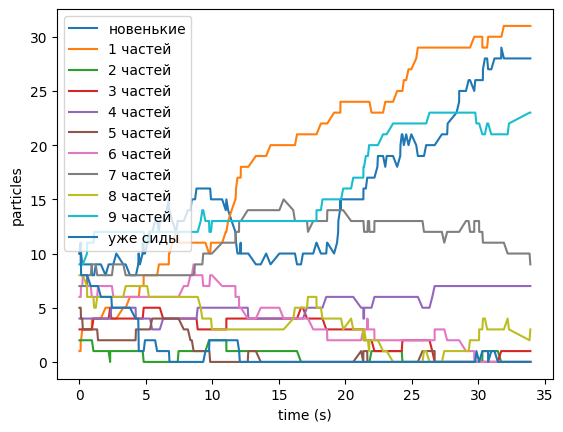

In [15]:
states = ["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"]
def plot_particles_history(particles_history, times):
    for i in range(m + 1):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

In [16]:
alpha = get_alpha()

k = 400
trj = 500
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = alpha
times[:, 0] = 0

for j in range(trj):
    alpha = get_alpha()

    lmb = 2
    delta = sum(lichers_)
    mu = 2
    phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu])

    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])


    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        if j == 0 or j == 1 or j == 2:
            print(f"after {i} step:")
            print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

after 1 step:
tau: [0.41172174 0.1604301  5.1428246  1.5089611  3.028897   0.0992133
 1.4138792  0.74389434 1.7073333  1.1750804  9.545396   0.29454854] 
phi: [2.         1.42857143 0.14025974 0.27012987 0.38181818 0.46753247
 0.51948052 0.52987013 0.49090909 0.39480519 0.23376623 2.        ] 
alpha: [10  1  2  3  4  5  6  7  8  8 11 55 54 52 49 45 40 34 27 19 11  0] 
event: 10
after 2 step:
tau: [0.31250843 0.0612168  5.0436115  1.4097478  2.9296837  6.281622
 1.3146658  0.64468104 1.60812    1.0758672  9.446182   0.19533524] 
phi: [2.         1.42857143 0.14025974 0.27012987 0.38181818 0.46753247
 0.51948052 0.52987013 0.49090909 0.39480519 0.23376623 2.        ] 
alpha: [10  1  2  3  3  6  6  7  8  8 11 55 54 52 49 46 40 34 27 19 11  0] 
event: 5
after 3 step:
tau: [0.25129163 1.418255   4.9823947  1.348531   2.8684669  6.220405
 1.253449   0.58346426 1.5469031  1.0146503  9.384966   0.13411844] 
phi: [2.         1.42857143 0.14025974 0.27012987 0.38181818 0.46753247
 0.51948052 0.5

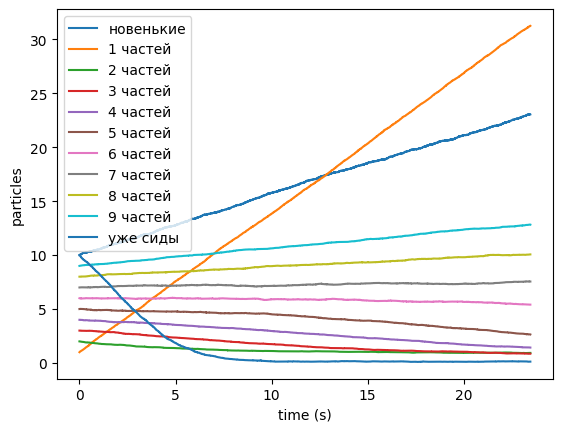

In [17]:
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [get_alpha()]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

merged = np.array(merged)[:, :m + 1]
plt.plot(total_times, merged, label=["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [18]:
print(alpha)

[ 34  91   0   0   0   0   3   4  23  11   0 132  41  41  41  41  41  38
  34  11   0   0]


In [19]:
print(tau)
print(eps)
print(p_gamma)
print(alpha)

[1.2697481e-01 1.6022873e+00 8.9183741e+00 3.4028235e+38 3.4028235e+38
 3.4028235e+38 3.4028235e+38 1.3277286e+00 1.8260974e+00 7.5842464e-01
 1.3028508e+01 3.4028235e+38]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0]]
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 